In [95]:
# !unzip -q my_data.zip
# !ls

lfw_with_more_than_2_pic      my_data	   sample_data	test.zip  train.zip
lfw_with_more_than_2_pic.zip  my_data.zip  test		train


In [0]:
import os
import csv
import pandas as pd
import numpy as np
import math

import matplotlib.pyplot as plt
from matplotlib import image

In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os

## Read Images

In [0]:
IMAGE_WIDTH = 96
IMAGE_HEIGHT = 96
COLOR_CHANNELS = 3

TOTAL_IMAGES_NUMBER = 9164
TRAIN_IMAGES_NUMBER = 6159
TEST_IMAGES_NUMBER = 3005

BATCH_SIZE = 8

In [0]:
# data_dir = './lfw_with_more_than_2_pic/'

In [0]:
data_dir = './my_data/'

In [0]:
train_image_names = []

In [0]:
test_image_names = []

In [0]:
for root, dirs, files in os.walk(data_dir):
    for directory in dirs:
        level = 0
        for directory_root, directory_dirs, directory_files in os.walk(root+ '/'+ directory):      
            if level != 0:
                for file in directory_files:
                    if directory == 'train':
                        train_image_names.append(file)
                    elif directory == 'test':
                        test_image_names.append(file)
            level = 1  

    break

training_tensor = np.ndarray(shape=(len(train_image_names), IMAGE_HEIGHT*IMAGE_WIDTH), dtype=np.float64)
testing_tensor = np.ndarray(shape=(len(test_image_names), IMAGE_HEIGHT*IMAGE_WIDTH), dtype=np.float64)

In [0]:
training_tensor = np.ndarray(shape=(len(train_image_names), IMAGE_HEIGHT*IMAGE_WIDTH), dtype=np.float64)
testing_tensor = np.ndarray(shape=(len(test_image_names), IMAGE_HEIGHT*IMAGE_WIDTH), dtype=np.float64)

In [0]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

In [0]:
for i in range(len(train_image_names)):
    
    img = rgb2gray(plt.imread(data_dir + "/train/" + train_image_names[i][:-9] + "/" + train_image_names[i]))
    training_tensor[i,:] = np.array(img, dtype='float64').flatten()

In [0]:
for i in range(len(test_image_names)):
    img = rgb2gray(plt.imread(data_dir + "/test/" + test_image_names[i][:-9] + "/" + test_image_names[i]))
    testing_tensor[i,:] = np.array(img, dtype='float64').flatten()

In [106]:
testing_tensor.shape

(26, 9216)

## Histogram Equalization

In [0]:
def image_histogram_equalization(image, number_bins=256):
    # get image histogram
    image_histogram, bins = np.histogram(image.flatten(), number_bins, density=True)
    cdf = image_histogram.cumsum() # cumulative distribution function
    cdf = 255 * cdf / cdf[-1] # normalize

    # use linear interpolation of cdf to find new pixel values
    image_equalized = np.interp(image.flatten(), bins[:-1], cdf)

    return image_equalized.reshape(image.shape)

Now transform all images to images with histogram equalization

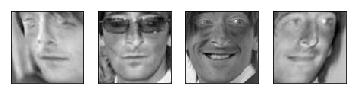

In [108]:
for i in range(4):
    img = training_tensor[i].reshape(IMAGE_HEIGHT, IMAGE_WIDTH)
    plt.subplot(2,4,1+i)
    plt.imshow(img, cmap='gray')
    plt.tick_params(labelleft = False, labelbottom = False, bottom = False, top = False, right = False, left=False, which='both')

In [0]:
for i in range(len(training_tensor)):
    training_tensor[i] = image_histogram_equalization(training_tensor[i])

In [0]:
for i in range(len(testing_tensor)):
    testing_tensor[i] = image_histogram_equalization(testing_tensor[i])

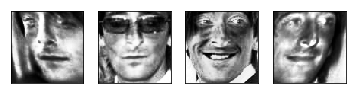

In [114]:
for i in range(4):
    img = training_tensor[i].reshape(IMAGE_HEIGHT, IMAGE_WIDTH)
    plt.subplot(2,4,1+i)
    plt.imshow(img, cmap='gray')
    plt.tick_params(labelleft = False, labelbottom = False, bottom = False, top = False, right = False, left=False, which='both')

## Mean face

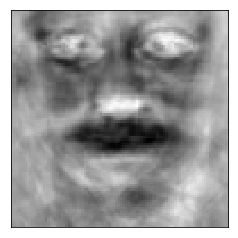

In [115]:
mean_face = np.zeros((1,IMAGE_HEIGHT*IMAGE_WIDTH))

for i in training_tensor:
    mean_face = np.add(mean_face,i)

mean_face = np.divide(mean_face,TRAIN_IMAGES_NUMBER).flatten()

plt.imshow(mean_face.reshape(IMAGE_HEIGHT, IMAGE_WIDTH), cmap='gray')
plt.tick_params(labelleft = False, labelbottom = False, bottom = False, top = False, right = False, left=False, which='both')

## Face centering

In [0]:
centered_train_tensor = np.ndarray((len(training_tensor), IMAGE_HEIGHT*IMAGE_WIDTH))
for i in range(len(training_tensor)):
    centered_train_tensor[i] = np.subtract(training_tensor[i], mean_face)

### Display centered faces

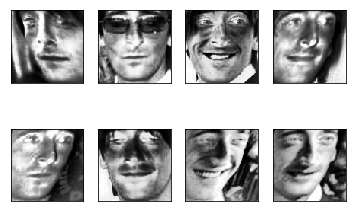

In [119]:
for i in range(BATCH_SIZE):
    img = centered_train_tensor[i].reshape(IMAGE_HEIGHT, IMAGE_WIDTH)
    plt.subplot(2,4,1+i)
    plt.imshow(img, cmap='gray')
    plt.tick_params(labelleft = False, labelbottom = False, bottom = False, top = False, right = False, left=False, which='both')

## Covariance matrix

In [0]:
cov_matrix = np.cov(centered_train_tensor)
cov_matrix = np.divide(cov_matrix, TRAIN_IMAGES_NUMBER)

## Eigenvalues and eigenvectors of the covariance matrix

In [0]:
eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)

## Transform images to vectors

In [122]:
print('Eigenvectors of Cov(X): \n%s' %eigenvectors)
print('\nEigenvalues of Cov(X): \n%s' %eigenvalues)

Eigenvectors of Cov(X): 
[[-1.06292679e-02 -1.28228542e-02 -1.17766063e-01 ... -3.40851207e-02
   4.07916498e-03  1.48770093e-04]
 [ 2.83346756e-02  1.18553593e-01 -1.59300694e-01 ...  4.86110165e-03
   5.38200001e-03  3.30481756e-02]
 [ 1.28133645e-01 -7.32864940e-03 -1.52979154e-01 ...  5.72466034e-02
  -1.08633671e-01  3.94505126e-02]
 ...
 [-9.72037650e-02 -2.78543593e-01 -3.33146920e-02 ... -2.89940308e-02
  -2.26203427e-01  1.39931441e-02]
 [ 1.60872423e-02 -9.76086701e-02  3.75797109e-02 ... -2.95392290e-01
  -5.09938658e-02  1.73372003e-01]
 [-1.42999542e-01 -1.30170472e-01  1.77146419e-01 ... -5.70726095e-02
  -6.38781691e-02 -1.66806492e-02]]

Eigenvalues of Cov(X): 
[7.99658476 6.24247042 4.31900685 3.16245751 2.78793215 2.37077273
 2.14932589 1.73613186 1.6236692  1.40546799 1.16403037 1.1028452
 1.01580569 0.90708533 0.81047201 0.75483289 0.69337392 0.61526777
 0.58941449 0.52057146 0.50585201 0.49836721 0.49107643 0.43407199
 0.40751597 0.40256957 0.38716077 0.35929458 0.

In [0]:
eig_pairs = [(eigenvalues[index], eigenvectors[:,index]) for index in range(len(eigenvalues))]

# Sort the eigen pairs in descending order:
eig_pairs.sort(reverse=True)
eigvalues_sort  = [eig_pairs[index][0] for index in range(len(eigenvalues))]
eigvectors_sort = [eig_pairs[index][1] for index in range(len(eigenvalues))]

## Find cumulative variance of each principal component

Cumulative proportion of variance explained vector: 
[0.15665731 0.27895059 0.36356221 0.42551641 0.48013347 0.52657816
 0.56868458 0.60269632 0.63450485 0.66203871 0.68484268 0.706448
 0.72634817 0.74411845 0.75999602 0.77478359 0.78836715 0.80042057
 0.81196751 0.82216578 0.83207569 0.84183897 0.85145941 0.85996311
 0.86794656 0.87583311 0.8834178  0.89045657 0.89738111 0.90387612
 0.90986001 0.91565683 0.92114434 0.92629661 0.93113927 0.93573047
 0.94028014 0.94448874 0.94843618 0.95232226 0.95602858 0.95968154
 0.96320886 0.96656943 0.96964893 0.97269422 0.97564807 0.97855295
 0.98128152 0.98393849 0.9864871  0.98886317 0.99111081 0.99318872
 0.99521934 0.99699008 0.9986431  1.        ]


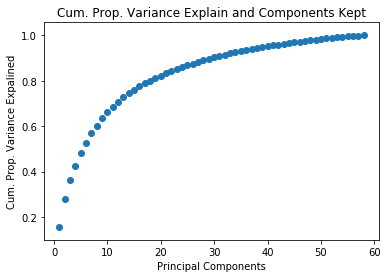

In [124]:
var_comp_sum = np.cumsum(eigvalues_sort)/sum(eigvalues_sort)

# Show cumulative proportion of varaince with respect to components
print("Cumulative proportion of variance explained vector: \n%s" %var_comp_sum)

# x-axis for number of principal components kept
num_comp = range(1,len(eigvalues_sort)+1)
plt.title('Cum. Prop. Variance Explain and Components Kept')
plt.xlabel('Principal Components')
plt.ylabel('Cum. Prop. Variance Expalined')

plt.scatter(num_comp, var_comp_sum)
plt.show()

## Reducing the number of eigenvectors

In [0]:
K = 50
reduced_data = np.array(eigvectors_sort[:K]).transpose()

### Find the projected data. This will form the eigen space.

In [0]:
proj_data = np.dot(training_tensor.transpose(),reduced_data)
proj_data = proj_data.transpose()

## Plot eigen faces

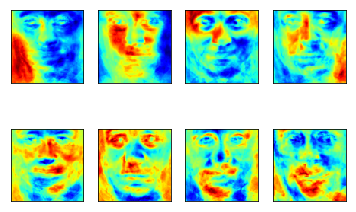

In [130]:
for i in range(BATCH_SIZE):
    img = proj_data[i].reshape(IMAGE_HEIGHT,IMAGE_WIDTH)
    plt.subplot(2,4,1+i)
    plt.imshow(img, cmap='jet')
    plt.tick_params(labelleft = False, labelbottom = False, bottom = False, top = False, right = False, left=False, which='both')

## Finding weights for each traning image

In [0]:
w = np.array([np.dot(proj_data,i) for i in centered_train_tensor])

In [132]:
w

array([[ 5.35067506e+07, -3.83852896e+08, -7.05293019e+06, ...,
        -1.57250192e+05,  1.09266800e+08,  1.90233014e+07],
       [ 7.11315651e+07, -3.36924307e+08, -1.72561746e+07, ...,
        -1.34390054e+06,  1.08226196e+08,  1.57031373e+07],
       [ 1.16462729e+08, -3.81768261e+08, -1.56924946e+07, ...,
         3.87155724e+05,  1.09087987e+08,  1.80109983e+07],
       ...,
       [ 1.41765211e+07, -4.77744873e+08,  1.36339028e+07, ...,
        -4.90503152e+05,  1.07374365e+08,  1.78450517e+07],
       [ 6.56367313e+07, -4.13922867e+08,  3.10281700e+07, ...,
        -8.07670943e+05,  1.07584507e+08,  1.81089346e+07],
       [-6.60634053e+06, -4.25186747e+08,  6.52239299e+07, ...,
         1.58044505e+05,  1.07320130e+08,  1.80384706e+07]])

## Reconize test images

In [0]:
count        = 0
num_images   = 0
correct_pred = 0
def recogniser(img, name_img, train_image_names,proj_data,w):
    global count,highest_min,num_images,correct_pred
    
    unknown_face        = image_histogram_equalization(rgb2gray(plt.imread(img)))
    num_images          += 1
    unknown_face_vector = np.array(unknown_face, dtype='float64').flatten()
    normalised_uface_vector = np.subtract(unknown_face_vector,mean_face)
    
    count+=1
    
    w_unknown = np.dot(proj_data, normalised_uface_vector)
    diff  = w - w_unknown
    norms = np.linalg.norm(diff, axis=1)
    index = np.argmin(norms)
    
    t1 = 100111536
    #t1 = 200535910.268 # working with 6 faces
    #t0 = 86528212
    t0 = 88831687
    #t0 = 143559033 # working with 6 faces
    
#     if norms[index] < t1:
#         if norms[index] < t0: # It's a face
#             if name_img[:-9] == train_image_names[index][:-9]:
#                 correct_pred += 1
    if name_img[:-9] == train_image_names[index][:-9]:
                correct_pred += 1
#     count+=1


In [0]:
for i in range(len(test_image_names)):
    recogniser(data_dir + "/test/" + test_image_names[i][:-9] + "/" + test_image_names[i],test_image_names[i], train_image_names,proj_data,w)

In [135]:
len(test_image_names)

26

In [136]:
print('Correct predictions: {}/{} = {}%'.format(correct_pred, num_images, correct_pred/num_images*100.00))

Correct predictions: 21/26 = 80.76923076923077%
